In [1]:

import datetime
import os
import time
import warnings
import torchvision

In [23]:
def plot_results(img):
    h, w = img.shape[1:]
            
    plt.figure(figsize=(16,10))
    unimage = unnorm(img)
    #image = (unimage*256).to(torch.uint8)
    image = unimage
    pil_img = torchvision.transforms.functional.to_pil_image(image)
    plt.imshow(pil_img)
    plt.show()

In [7]:
import torch
import torch.utils.data
import torchvision
import torchvision.transforms
import utils
from sampler import RASampler
from torch import nn
from torch.utils.data.dataloader import default_collate


from torchvision.transforms.functional import InterpolationMode
from transforms import get_mixup_cutmix


In [8]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        output_tensor = []
        for t, m, s in zip(tensor, self.mean, self.std):
            output_tensor.append(t.mul(s).add(m))
            # t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return torch.stack(output_tensor, dim=0)

unnorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [19]:
import argparse
class Args(argparse.Namespace):
    def __init__(self):
        self.data_path='/media/mak/ssd/imagenet/ILSVRC/Data/CLS-LOC'
        self.model='vit_b_16'
        self.device='cuda'
        self.batch_size=2
        self.epochs=300
        self.workers=16
        self.opt='adamw'
        self.lr=0.003
        self.momentum=0.9
        self.weight_decay=0.3
        self.norm_weight_decay=None
        self.bias_weight_decay=None
        self.transformer_embedding_decay=None
        self.label_smoothing=0.11
        self.mixup_alpha=0.2
        self.cutmix_alpha=1.0
        self.lr_scheduler='cosineannealinglr'
        self.lr_warmup_epochs=30
        self.lr_warmup_method='linear'
        self.lr_warmup_decay=0.033
        self.lr_step_size=30
        self.lr_gamma=0.1
        self.lr_min=0.0
        self.print_freq=10
        self.output_dir='.'
        self.resume=''
        self.start_epoch=0
        self.cache_dataset=False
        self.sync_bn=False
        self.test_only=False
        self.auto_augment='ra'
        self.ra_magnitude=9
        self.augmix_severity=3
        self.random_erase=0.0
        self.amp=True
        self.world_size=1
        self.dist_url='env://'
        self.model_ema=True
        self.model_ema_steps=32
        self.model_ema_decay=0.99998
        self.use_deterministic_algorithms=False
        self.interpolation='bilinear'
        self.val_resize_size=256
        self.val_crop_size=224
        self.train_crop_size=224
        self.clip_grad_norm=1.0
        self.ra_sampler=True
        self.ra_reps=3
        self.weights=None
        self.backend='pil'
        self.use_v2=False
args = Args()

In [16]:
device = torch.device(args.device)
device

device(type='cuda')

In [21]:
from train import load_data

args.distributed = False

if args.use_deterministic_algorithms:
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)
else:
    torch.backends.cudnn.benchmark = True

train_dir = os.path.join(args.data_path, "train")
val_dir = os.path.join(args.data_path, "val")
dataset, dataset_test, train_sampler, test_sampler = load_data(train_dir, val_dir, args)

Loading data
Loading training data
Took 2.289463758468628
Loading validation data
Creating data loaders


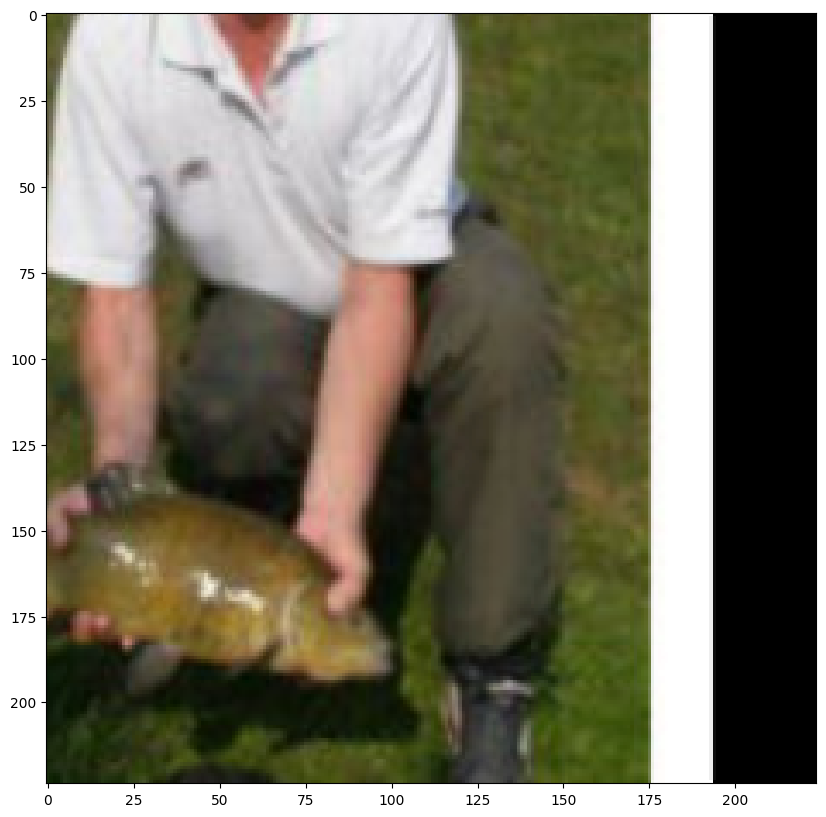

In [67]:
# repeat to see different augmentations
plot_results(dataset[0][0])

In [68]:
from train import get_mixup_cutmix
num_classes = len(dataset.classes)
mixup_cutmix = get_mixup_cutmix(
    mixup_alpha=args.mixup_alpha, cutmix_alpha=args.cutmix_alpha, num_classes=num_classes, use_v2=args.use_v2
)
if mixup_cutmix is not None:

    def collate_fn(batch):
        return mixup_cutmix(*default_collate(batch))

else:
    collate_fn = default_collate

data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=args.batch_size,
    sampler=train_sampler,
    num_workers=args.workers,
    pin_memory=True,
    collate_fn=collate_fn,
)
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=args.batch_size, sampler=test_sampler, num_workers=args.workers, pin_memory=True
)

/home/mak/miniconda3/envs/vit/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/home/mak/miniconda3/envs/vit/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


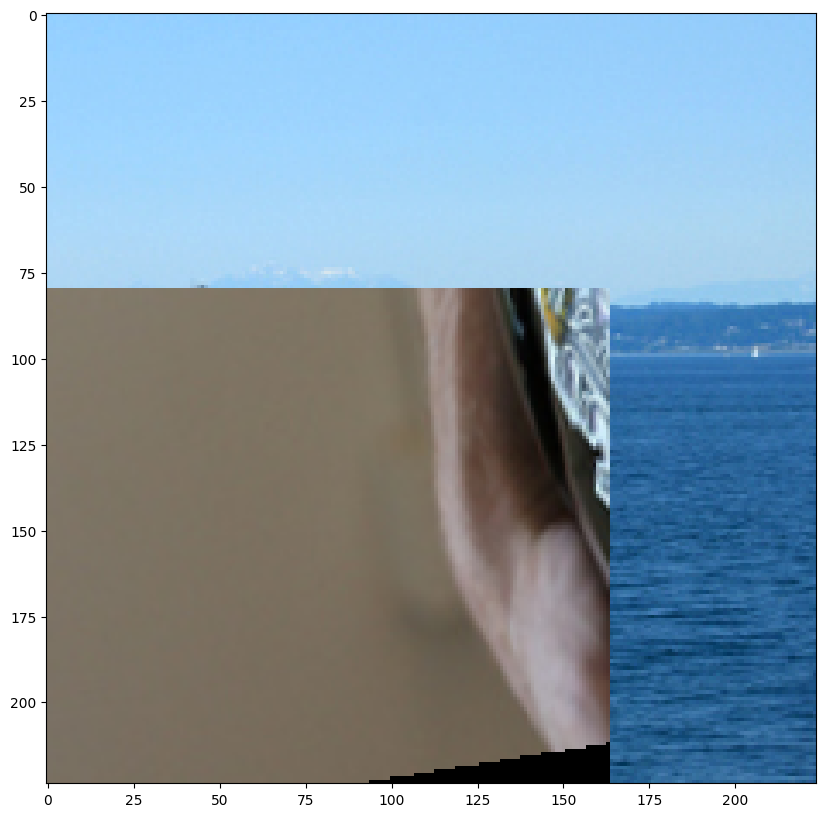

In [70]:
for images, labels in data_loader:
    break
plot_results(images[0])

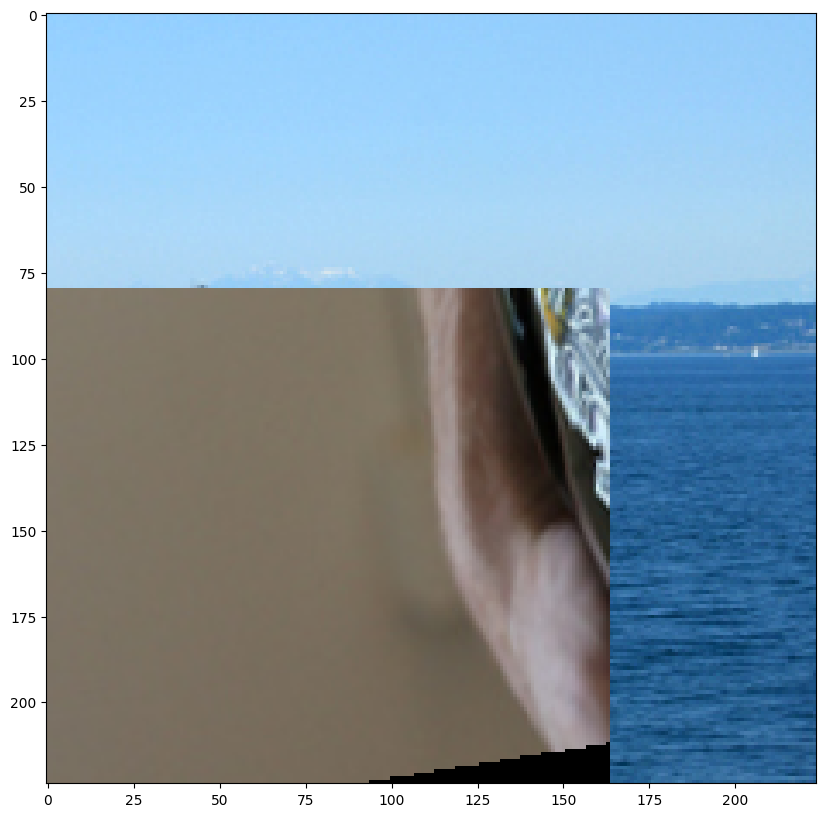

In [75]:
plot_results(images[0])

In [76]:
print("Creating model")
model = torchvision.models.get_model(args.model, weights=args.weights, num_classes=num_classes)
model.to(device)

Creating model


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [79]:
args.model

'vit_b_16'

In [80]:
model(images.to(device))

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<AddmmBackward0>)